# Drone-based Road Detection and Path Planning

This notebook uses YOLO for segmentation and detection, and A* for pathfinding on drone imagery.

In [1]:
# --- Imports & Setup ---
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import heapq
from collections import deque
import random
import math
from tqdm import tqdm

In [2]:
# --- A* PATHFINDING FUNCTION ---
def astar_pathfinding(grid, start, end):
    rows, cols = grid.shape
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}

    def h(p1, p2):
        return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        neighbors = [(current[0]+i, current[1]+j) for i, j in [(-1,0), (1,0), (0,-1), (0,1)]]
        for neighbor in neighbors:
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid[neighbor] == 1:
                tentative = g_score[current] + 1
                if neighbor not in g_score or tentative < g_score[neighbor]:
                    g_score[neighbor] = tentative
                    f_score = tentative + h(neighbor, end)
                    heapq.heappush(open_set, (f_score, neighbor))
                    came_from[neighbor] = current
    return []

In [3]:
# --- HELPER: Find Nearest Road Point ---
def find_nearest_road(mask, point):
    y, x = point
    visited = set()
    queue = deque([(y, x)])
    while queue:
        cy, cx = queue.popleft()
        if (cy, cx) in visited or not (0 <= cy < mask.shape[0] and 0 <= cx < mask.shape[1]):
            continue
        visited.add((cy, cx))
        if mask[cy, cx] == 1:
            return (cy, cx)
        for dy, dx in [(-1,0), (1,0), (0,-1), (0,1)]:
            queue.append((cy+dy, cx+dx))
    return point

In [4]:
# --- Load models ---
seg_model = YOLO(r"C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\segmentation-project\aerial-road-building30\weights\best.pt")
seg_model.to("cuda")
det_model = YOLO(r"C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\best.pt")
det_model.to("cuda")

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_

In [5]:
import os
import cv2
import numpy as np
import random
import heapq

#==== A* PATHFINDING ===
def astar_pathfinding(mask, start, goal):
    h, w = mask.shape
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    visited = set()

    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        visited.add(current)

        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (current[0] + dy, current[1] + dx)
            if (0 <= neighbor[0] < h and 0 <= neighbor[1] < w and
                mask[neighbor] == 1 and neighbor not in visited):
                tentative_g = g_score[current] + 1
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f, neighbor))

    # Goal unreachable — return longest explored path
    if came_from:
        farthest = max(g_score, key=g_score.get)
        path = []
        while farthest in came_from:
            path.append(farthest)
            farthest = came_from[farthest]
        path.append(start)
        return path[::-1]

    return []

# === IMAGE PROCESSING LOOP ===
folder_path = r"C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\roaddataset6\test"
output_folder = os.path.join(folder_path, "outputs")
os.makedirs(output_folder, exist_ok=True)

for file_name in os.listdir(folder_path):
    if not file_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(folder_path, file_name)
    original = cv2.imread(img_path)
    if original is None:
        print(f"❌ Failed to load: {file_name}")
        continue

    try:
        h, w = original.shape[:2]
        resized_full = cv2.resize(original, (416, 416))
        seg_full = seg_model.predict(source=resized_full, imgsz=416, conf=0.1, verbose=False)[0]
        mask_full = np.zeros((416, 416), dtype=np.uint8)
        if seg_full.masks is not None:
            for seg, cls in zip(seg_full.masks.data, seg_full.boxes.cls):
                if int(cls) == 0:
                    m = (seg.cpu().numpy() > 0.5).astype(np.uint8)
                    mask_full = np.maximum(mask_full, m)

        mask_fullres = cv2.resize(mask_full, (w, h), interpolation=cv2.INTER_NEAREST)

        grid_size = 10
        gh, gw = h // grid_size, w // grid_size
        mask_grid = np.zeros((h, w), dtype=np.uint8)

        for i in range(grid_size):
            for j in range(grid_size):
                y1, y2 = i * gh, (i + 1) * gh
                x1, x2 = j * gw, (j + 1) * gw
                patch = original[y1:y2, x1:x2]
                if patch.shape[0] < 10 or patch.shape[1] < 10:
                    continue
                patch_resized = cv2.resize(patch, (416, 416))
                seg_patch = seg_model.predict(source=patch_resized, imgsz=416, conf=0.1, verbose=False)[0]
                patch_mask = np.zeros((416, 416), dtype=np.uint8)
                if seg_patch.masks is not None:
                    for seg, cls in zip(seg_patch.masks.data, seg_patch.boxes.cls):
                        if int(cls) == 0:
                            m = (seg.cpu().numpy() > 0.5).astype(np.uint8)
                            patch_mask = np.maximum(patch_mask, m)
                resized_patch_mask = cv2.resize(patch_mask, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
                mask_grid[y1:y2, x1:x2] = np.maximum(mask_grid[y1:y2, x1:x2], resized_patch_mask)

        combined_mask = np.maximum(mask_fullres, mask_grid)
        kernel = np.ones((50, 50), np.uint8)
        mask_cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

        det_img = original.copy()
        car_points = []
        boxes = []

        for i in range(grid_size):
            for j in range(grid_size):
                y1, y2 = i * gh, (i + 1) * gh
                x1, x2 = j * gw, (j + 1) * gw
                patch = original[y1:y2, x1:x2]
                det_result = det_model.predict(source=patch, imgsz=416, conf=0.2, verbose=False)[0]
                if det_result.boxes is not None:
                    for box in det_result.boxes.xyxy:
                        x1b, y1b, x2b, y2b = map(int, box)
                        abs_x1 = x1 + x1b
                        abs_y1 = y1 + y1b
                        abs_x2 = x1 + x2b
                        abs_y2 = y1 + y2b
                        cx = (abs_x1 + abs_x2) // 2
                        cy = (abs_y1 + abs_y2) // 2
                        abs_x1, abs_x2 = np.clip([abs_x1, abs_x2], 0, w - 1)
                        abs_y1, abs_y2 = np.clip([abs_y1, abs_y2], 0, h - 1)

                        boxes.append(((abs_x1, abs_y1, abs_x2, abs_y2), (cy, cx)))
                        if mask_cleaned[cy, cx] == 1:
                            car_points.append((cy, cx))

        if not car_points:
            print(f"🚫 No cars on road in {file_name}. Skipping.")
            continue
        start = random.choice(car_points)

        for (x1, y1, x2, y2), (cy, cx) in boxes:
            if (cy, cx) == start:
                cv2.rectangle(det_img, (x1, y1), (x2, y2), (0, 0, 255), -1)
            elif mask_cleaned[cy, cx] == 1:
                cv2.rectangle(det_img, (x1, y1), (x2, y2), (0, 255, 255), -1)
            else:
                cv2.rectangle(det_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

        edge_points = []
        for x in range(w):
            if mask_cleaned[0, x] == 1:
                edge_points.append((0, x))
            if mask_cleaned[h - 1, x] == 1:
                edge_points.append((h - 1, x))
        for y in range(h):
            if mask_cleaned[y, 0] == 1:
                edge_points.append((y, 0))
            if mask_cleaned[y, w - 1] == 1:
                edge_points.append((y, w - 1))

        if not edge_points:
            print(f"🚫 No road at image edge in {file_name}. Skipping.")
            continue
        
        # Find the closest edge point to the start
        def euclidean_dist(p1, p2):
            return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

        end = min(edge_points, key=lambda pt: euclidean_dist(start, pt))


        path = astar_pathfinding(mask_cleaned, start, end)

        if path:
            path_pts = np.array([[p[1], p[0]] for p in path], np.int32).reshape((-1, 1, 2))
            cv2.polylines(det_img, [path_pts], isClosed=False, color=(0, 255, 0), thickness=25)
            cv2.circle(det_img, (start[1], start[0]), 10, (0, 0, 255), -1)
            cv2.circle(det_img, (end[1], end[0]), 10, (255, 0, 255), -1)
        else:
            print("⚠️ No path available from start to end.")

        overlay = det_img.copy()
        mask_color = np.zeros_like(det_img)
        mask_color[mask_cleaned == 1] = (255, 255, 0)
        cv2.addWeighted(mask_color, 0.3, overlay, 0.7, 0, overlay)

        result_path = os.path.join(output_folder, f"result_{file_name}")
        cv2.imwrite(result_path, overlay)
        print(f"✅ Processed and saved: {result_path}")

    except Exception as e:
        print(f"🚫 Error processing {file_name}: {e}")


✅ Processed and saved: C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\roaddataset6\test\outputs\result_KTest_01.jpg
✅ Processed and saved: C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\roaddataset6\test\outputs\result_KTest_02.jpg
✅ Processed and saved: C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\roaddataset6\test\outputs\result_KTest_03.jpg
✅ Processed and saved: C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\roaddataset6\test\outputs\result_KTest_04.jpg


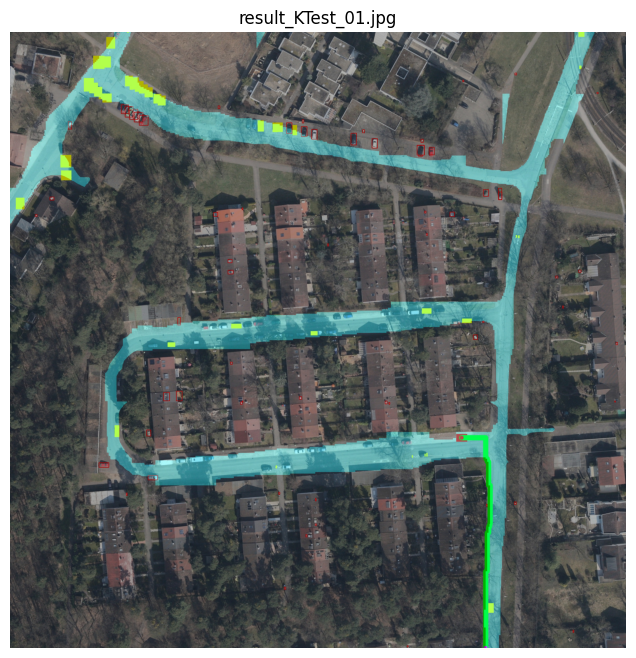

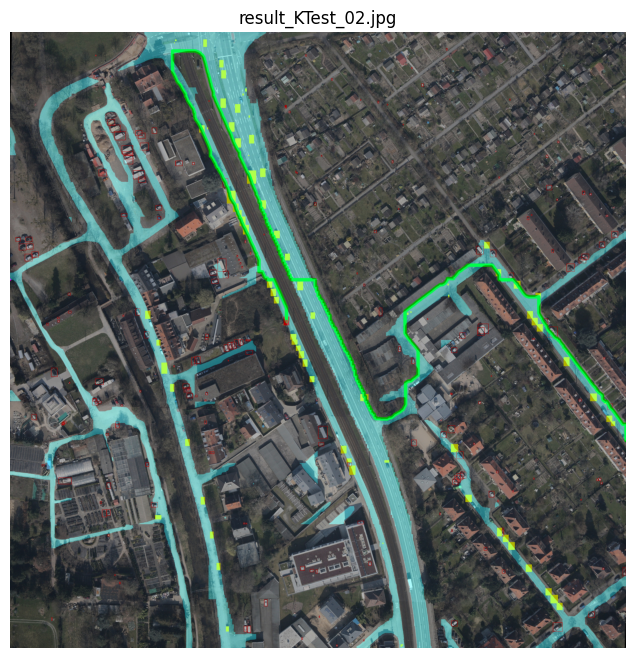

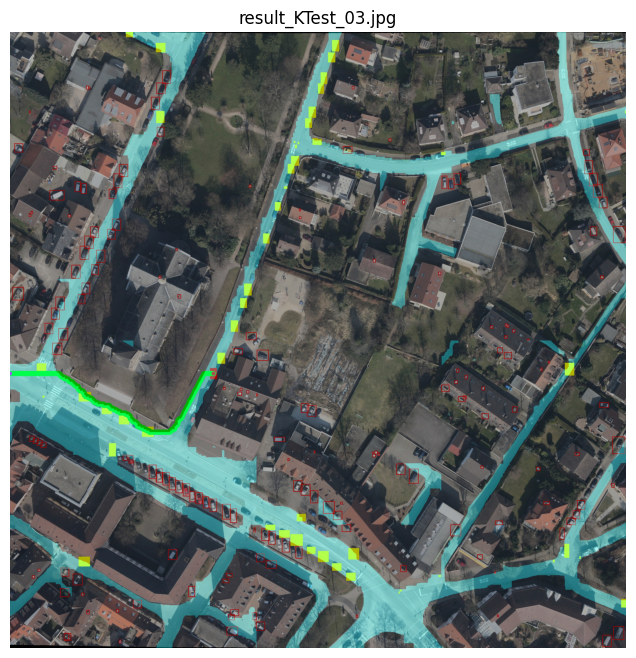

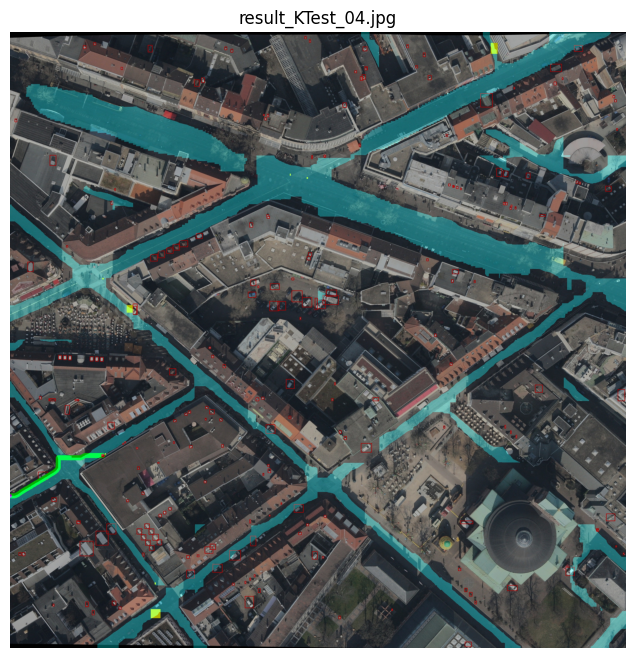

In [6]:
from imutils import paths
import matplotlib.pyplot as plt  
import os
log_dir = r"C:\Users\adity\OneDrive\Desktop\Desktop\College\Semester 2\Elements of Computing System 2\roaddataset6\test\outputs"
from PIL import Image
for image_path in sorted(paths.list_images(log_dir)):
    img = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()